## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Device Configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device used : ', device)

Device used :  cpu


## Hyper Parameters

In [3]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

## Lets first look at the data

### The directory structure is:
$$ ./data/chest_xray-$$
$$    --train      $$
$$      -NORMAL   $$
$$      -PNEUMONIA$$
$$    --test       $$
$$      -NORMAL   $$
$$      -PNEUMONIA$$
$$    --val        $$
$$      -NORMAL   $$
$$      -PNEUMONIA$$

### After checking each folder from data; we conclude that the x-ray images are of different dimensions, so need to be resized first

In [4]:
import os
os.getcwd()

'D:\\mylab\\XrayPneumonia'

In [5]:
os.listdir()

['.ipynb_checkpoints', '01_cnn_custom.ipynb', 'data', 'details.txt']

In [6]:
train_data_path = 'data/chest_xray/train/'
test_data_path = 'data/chest_xray/test/'

In [7]:
print(train_data_path)

data/chest_xray/train/


In [8]:
## REsize the data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)), 
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(),
    transforms.ToTensor()    
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)), 
    transforms.ToTensor()    
   
])

## Load Dataset

In [9]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

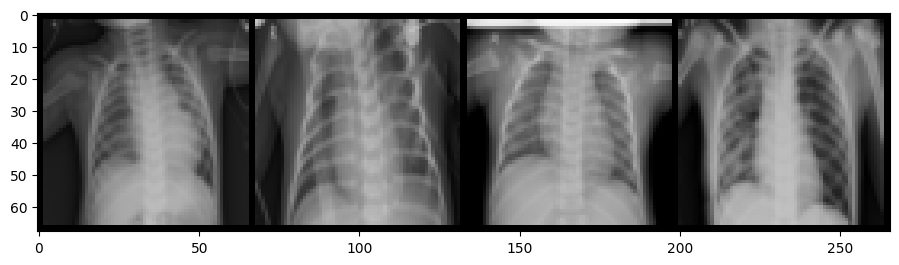

labels :  tensor([1, 1, 0, 1])
torch.Size([4, 3, 64, 64])


In [10]:
## Lets visualize few images
# def show_transformed_images(dataset):
#     train_loader = torch.utils.data.DataLoader(dataset, batch_size=24, shuffle=True)    #with this batch size we can control no.of images to plot
#     image = next(iter(train_loader))
#     images, labels = image
    
#     grid = torchvision.utils.make_grid(images, nrows=3)
#     plt.figure(figsize=(11,11))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     print('labels : ', labels)

def imshow(img):
    img = img   # or xunnormalize by img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

#Show images
plt.figure(figsize=(11,11))
imshow(torchvision.utils.make_grid(images))
print('labels : ', labels)
print(images.shape)

In [11]:
# show_transformed_images(train_dataset)    # 0:NORMAL, 1:PNEUMONIA


## Define Classes

In [12]:
classes = ('NORMAL', 'PNEUMONIA')

## Create CNN Model

#### Input -> Convolution -> Relu -> MaxPool -> Convolution -> Relu -> MaxPool -> FC -> FC -> FC -> Softmax

In [13]:
## Visualizing each operation values
conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
pool1 = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
pool2 = nn.MaxPool2d(2,2)
print('image shape : ', images.shape)   # (batch_size, channel, H, W)
x = conv1(images)
print('conv1 shape', x.shape)   # (n-f+2p/s) + 1 
x = pool1(x)
print('pool1 shape', x.shape)   
x = conv2(x)
print('conv2 shape', x.shape)   
x = pool2(x)
print('pool2 shape', x.shape) 

image shape :  torch.Size([4, 3, 64, 64])
conv1 shape torch.Size([4, 16, 62, 62])
pool1 shape torch.Size([4, 16, 31, 31])
conv2 shape torch.Size([4, 32, 29, 29])
pool2 shape torch.Size([4, 32, 14, 14])


In [19]:
class ConvNet1(nn.Module):
    def __init__(self, in_channels=1, num_classes = 2):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,kernel_size=3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*14*14, num_classes)
        
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # To pass this activated output to FC, we need to flatten it
        x = x.view(-1, 32*14*14)    #-1:automatically find correct size(here, its no.of samples)
        
        #Lets call 1st FC layer
        x = self.fc1(x)
        return x

## Initialize Model

In [20]:
model = ConvNet1().to(device)

## Loss and Optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train Network

In [22]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Backward and Optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 250 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss : {loss.item():.4f}')
                  
print('Finished Training')

Epoch [1/5], Step [250/1304], Loss : 0.3403
Epoch [1/5], Step [500/1304], Loss : 0.5545
Epoch [1/5], Step [750/1304], Loss : 0.3630
Epoch [1/5], Step [1000/1304], Loss : 0.8147
Epoch [1/5], Step [1250/1304], Loss : 0.3547
Epoch [2/5], Step [250/1304], Loss : 0.5360
Epoch [2/5], Step [500/1304], Loss : 0.3374
Epoch [2/5], Step [750/1304], Loss : 0.3126
Epoch [2/5], Step [1000/1304], Loss : 0.3255
Epoch [2/5], Step [1250/1304], Loss : 0.3264
Epoch [3/5], Step [250/1304], Loss : 0.2121
Epoch [3/5], Step [500/1304], Loss : 0.3447
Epoch [3/5], Step [750/1304], Loss : 0.0946
Epoch [3/5], Step [1000/1304], Loss : 0.7581
Epoch [3/5], Step [1250/1304], Loss : 0.1531
Epoch [4/5], Step [250/1304], Loss : 0.1650
Epoch [4/5], Step [500/1304], Loss : 0.7089
Epoch [4/5], Step [750/1304], Loss : 0.0289
Epoch [4/5], Step [1000/1304], Loss : 0.0406
Epoch [4/5], Step [1250/1304], Loss : 0.0016
Epoch [5/5], Step [250/1304], Loss : 0.1422
Epoch [5/5], Step [500/1304], Loss : 0.6410
Epoch [5/5], Step [750/1

## Check Accuracy

In [23]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network : {acc} % ')
    
    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]} : {acc} %')

Accuracy of the network : 76.76282051282051 % 
Accuracy of NORMAL : 41.88034188034188 %
Accuracy of PNEUMONIA : 97.6923076923077 %
